## First example

In [1]:
import numpy as np
from astropy import units as u

from matplotlib import ticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import ode

from poliastro.bodies import Earth
from poliastro.twobody import State
from poliastro.examples import iss

from poliastro.twobody.propagation import func_twobody

from poliastro.util import norm

In [2]:
from IPython.html.widgets import interact, fixed

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
def state_to_vector(ss):
    r, v = ss.rv()
    x, y, z = r.to(u.km).value
    vx, vy, vz = v.to(u.km / u.s).value
    return np.array([x, y, z, vx, vy, vz])

In [4]:
u0 = state_to_vector(iss)
u0

array([  8.59072560e+02,  -4.13720368e+03,   5.29556871e+03,
         7.37289205e+00,   2.08223573e+00,   4.39999794e-01])

In [5]:
t = np.linspace(0, 10 * iss.period, 500).to(u.s).value
t[:10]

array([    0.        ,   111.36236546,   222.72473091,   334.08709637,
         445.44946182,   556.81182728,   668.17419274,   779.53655819,
         890.89892365,  1002.2612891 ])

In [6]:
dt = t[1] - t[0]
dt

111.36236545586407

In [7]:
k = Earth.k.to(u.km**3 / u.s**2).value

I cannot provide the Jacobian since I don't know the form of the acceleration in advance.

In [8]:
def constant_thrust(t0, u, k, **kwargs):
    _, _, _, vx, vy, vz = u
    v = (vx**2 + vy**2 + vz**2)**.5
    thrust = kwargs.get('thrust')
    a = thrust * np.array([vx / v, vy / v, vz / v])
    return a

constant_thrust(t[0], u0, k, thrust=1e-5)

array([  9.60774274e-06,   2.71339728e-06,   5.73371317e-07])

In [9]:
help(func_twobody)

Help on function func_twobody in module poliastro.twobody.propagation:

func_twobody(t0, u, a, k, kwargs)
    Differential equation for generic twobody motion.
    
    Parameters
    ----------
    u : ndarray
        Six component state vector [x, y, z, vx, vy, vz] (km, km/s).
    t0 : float
        Time.
    a : function(t0, u, k, **kwargs)
        Non Keplerian acceleration.
    k : float
        Standard gravitational parameter.
    kwargs : dict
        Dictionary of extra parameters for both the objective function and
        the user-supplied acceleration function.



In [10]:
res = np.zeros((t.size, 6))
res[0] = u0
ii = 1

thrust = 1e-5

rr = ode(func_twobody).set_integrator('dop853')  # All parameters by default
rr.set_initial_value(u0, t[0])
rr.set_f_params(constant_thrust, k, {'thrust': thrust})

while rr.successful() and rr.t + dt < t[-1]:
    rr.integrate(rr.t + dt)
    res[ii] = rr.y
    ii += 1

res[:5]

array([[  8.59072560e+02,  -4.13720368e+03,   5.29556871e+03,
          7.37289205e+00,   2.08223573e+00,   4.39999794e-01],
       [  1.67120230e+03,  -3.87307826e+03,   5.30240753e+03,
          7.19314459e+00,   2.65498807e+00,  -3.17311723e-01],
       [  2.45692619e+03,  -3.54744244e+03,   5.22508987e+03,
          6.89930195e+00,   3.18546188e+00,  -1.06939136e+00],
       [  3.20378664e+03,  -3.16547981e+03,   5.06486636e+03,
          6.49612276e+00,   3.66524518e+00,  -1.80427363e+00],
       [  3.89995423e+03,  -2.73326637e+03,   4.82430604e+03,
          5.99011411e+00,   4.08674543e+00,  -2.51027861e+00]])

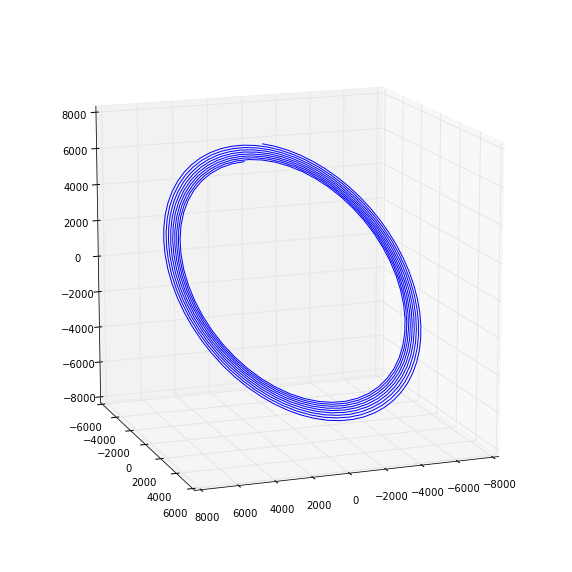

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(*res[:, :3].T)

ax.view_init(14, 70)

## Interactivity

In [12]:
def plot_iss(thrust=0.1, mass=2000.):
    res = np.zeros((t.size, 6))
    res[0] = u0
    ii = 1

    thrust /= mass

    rr = ode(func_twobody).set_integrator('dop853')  # All parameters by default
    rr.set_initial_value(u0, t[0])
    rr.set_f_params(constant_thrust, k, {'thrust': thrust})

    while rr.successful() and rr.t + dt < t[-1]:
        rr.integrate(rr.t + dt)
        res[ii] = rr.y
        ii += 1

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim(-20e3, 20e3)
    ax.set_ylim(-20e3, 20e3)
    ax.set_zlim(-20e3, 20e3)

    ax.view_init(14, 70)

    return ax.plot(*res[:, :3].T)

<function __main__.plot_iss>

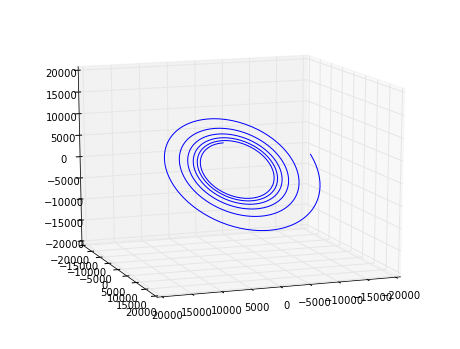

In [13]:
interact(plot_iss, thrust=(0.0, 0.2, 0.001), mass=fixed(2000.))

## Error checking

In [14]:
rtol = 1e-13
full_periods = 2

In [15]:
u0 = state_to_vector(iss)
tf = ((2 * full_periods + 1) * iss.period / 2).to(u.s).value

u0, tf

(array([  8.59072560e+02,  -4.13720368e+03,   5.29556871e+03,
          7.37289205e+00,   2.08223573e+00,   4.39999794e-01]),
 13892.455090619042)

In [16]:
iss_f_kep = iss.propagate(tf * u.s, rtol=1e-18)

In [17]:
rr = ode(func_twobody).set_integrator('dop853', rtol=rtol, nsteps=1000)
rr.set_initial_value(u0, 0.0)
rr.set_f_params(constant_thrust, k, {'thrust': 0.0})  # Zero thrust

rr.integrate(rr.t + tf)

if rr.successful():
    uf = rr.y

    r, v = uf[:3] * u.km, uf[3:] * u.km / u.s
    iss_f_num = State.from_vectors(Earth, r, v, iss.epoch + tf * u.s)
else:
    raise RuntimeError

In [18]:
assert np.allclose(iss_f_num.r, iss_f_kep.r, rtol=rtol)
assert np.allclose(iss_f_num.v, iss_f_kep.v, rtol=rtol)

In [19]:
assert np.allclose(iss_f_num.a, iss_f_kep.a, rtol=rtol)
assert np.allclose(iss_f_num.ecc, iss_f_kep.ecc, rtol=rtol)
assert np.allclose(iss_f_num.inc, iss_f_kep.inc, rtol=rtol)
assert np.allclose(iss_f_num.raan, iss_f_kep.raan, rtol=rtol)
assert np.allclose(iss_f_num.argp, iss_f_kep.argp, rtol=rtol)
assert np.allclose(iss_f_num.nu, iss_f_kep.nu, rtol=rtol)

Too bad I cannot access the internal state of the solver. I will have to do it in a blackbox way.

In [20]:
u0 = state_to_vector(iss)
full_periods = 4

tof_vector = np.linspace(0, ((2 * full_periods + 1) * iss.period / 2).to(u.s).value, num=100)
rtol_vector = np.logspace(-3, -12, num=30)

res_array = np.zeros((rtol_vector.size, tof_vector.size))
for jj, tof in enumerate(tof_vector):
    rf, vf = iss.propagate(tof * u.s, rtol=1e-12).rv()
    for ii, rtol in enumerate(rtol_vector):
        rr = ode(func_twobody).set_integrator('dop853', rtol=rtol, nsteps=1000)
        rr.set_initial_value(u0, 0.0)
        rr.set_f_params(constant_thrust, k, {'thrust': 0.0})  # Zero thrust

        rr.integrate(rr.t + tof)

        if rr.successful():
            uf = rr.y

            r, v = uf[:3] * u.km, uf[3:] * u.km / u.s

            res = max(norm((r - rf) / rf), norm((v - vf) / vf))
        else:
            res = np.nan

        res_array[ii, jj] = res

/home/juanlu/.miniconda3/envs/poliastro34/lib/python3.4/site-packages/scipy/integrate/_ode.py:1019: UserWarning: dop853: step size becomes too small
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


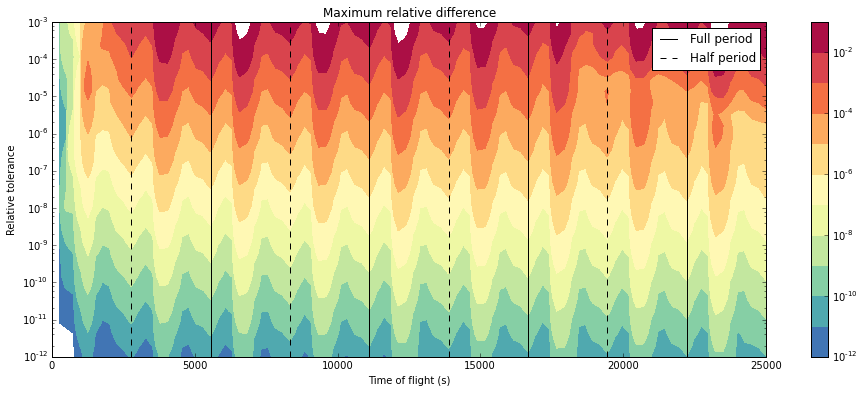

In [21]:
fig, ax = plt.subplots(figsize=(16, 6))

xx, yy = np.meshgrid(tof_vector, rtol_vector)

cs = ax.contourf(xx, yy, res_array, levels=np.logspace(-12, -1, num=12),
             locator=ticker.LogLocator(), cmap=plt.cm.Spectral_r)
fig.colorbar(cs)

for nn in range(full_periods + 1):
    lf = ax.axvline(nn * iss.period.to(u.s).value, color='k', ls='-')
    lh = ax.axvline((2 * nn + 1) * iss.period.to(u.s).value / 2, color='k', ls='--')

ax.set_yscale('log')

ax.set_xlabel("Time of flight (s)")
ax.set_ylabel("Relative tolerance")

ax.set_title("Maximum relative difference")

ax.legend((lf, lh), ("Full period", "Half period"))